# Load the dataset

In [1]:
import pandas as pd
import numpy as np

# Define file paths
train_data_path = "../../DataCollection/Data/cleaned_train.csv"  # Update path if necessary
test_data_path = "../../DataCollection/Data/cleaned_train.csv"    # Update path if necessary

# Load the training dataset
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# Display dataset shapes
print("Training Dataset Shape:", df_train.shape)
print("Testing Dataset Shape:", df_test.shape)

# Show first few rows to verify
print(df_train.head())
print(df_test.head())

Training Dataset Shape: (339629, 91)
Testing Dataset Shape: (339629, 91)
   month  year         town  town_LE  town_YISHUN  town_WOODLANDS  \
0      4  2021   ANG MO KIO        0        False           False   
1      6  2021  BUKIT MERAH        4        False           False   
2      7  2023    SEMBAWANG       19        False           False   
3      8  2021    WOODLANDS       24        False            True   
4      3  2018       YISHUN       25         True           False   

   town_TOA PAYOH  town_TAMPINES  town_SERANGOON  town_SENGKANG  ...  \
0           False          False           False          False  ...   
1           False          False           False          False  ...   
2           False          False           False          False  ...   
3           False          False           False          False  ...   
4           False          False           False          False  ...   

   Secondary_within_1km  Secondary_nearest  JuniorCollege_within_1km  \
0      

Define Features and Targets

In [2]:
# Define target variable
target_column = "resale_price"

features_final = [
    'month', 'year', 'town_LE', 'flat_type_LE', 'storey_range_LE', 
    'price_per_sqm', 'flat_model_LE', 'lease_commence_date', 
    'Latitude', 'Longitude', 'LTAMRTStation_within_1km', 'MallCoordinates_within_1km',
    'Hawker_within_1km', 'PreSchool_within_1km', 'Primary_within_1km',
    'Secondary_within_1km', 'JuniorCollege_within_1km', 'MixedLevel_within_1km',
    'NParks_within_1km', 'Sports_within_1km', 'remaining_lease'
]

X_train = df_train[features_final]
y_train = df_train['resale_price']

X_test = df_test[features_final]
y_test = df_test['resale_price']

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)


# Show first few rows to verify
print(X_train.head())
print(X_test.head())


Training Features Shape: (339629, 21)
Testing Features Shape: (339629, 21)
   month  year  town_LE  flat_type_LE  storey_range_LE  price_per_sqm  \
0      4  2021        0             3                2    4395.604396   
1      6  2021        4             4                1    4364.406780   
2      7  2023       19             1                4    6875.000000   
3      8  2021       24             3                4    4833.333333   
4      3  2018       25             2                4    4074.626866   

   flat_model_LE  lease_commence_date  Latitude   Longitude  ...  \
0             12                 1981  1.375815  103.838172  ...   
1             17                 1978  1.273850  103.811310  ...   
2              8                 2019  1.443739  103.816274  ...   
3             16                 1988  1.433222  103.781636  ...   
4             12                 1985  1.432211  103.834084  ...   

   MallCoordinates_within_1km  Hawker_within_1km  PreSchool_within_1km  \
0  

Ensure Train & Test Sets Have Same Features

In [3]:
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

print("✅ Train & Test features aligned!")
print("Final X_train shape:", X_train.shape)
print("Final X_test shape:", X_test.shape)

✅ Train & Test features aligned!
Final X_train shape: (339629, 21)
Final X_test shape: (339629, 21)


In [4]:
# Convert DataFrame to NumPy array
X_train = np.array(X_train)
X_test = np.array(X_test)

# Convert Target (y_train, y_test) to NumPy arrays as well
y_train = np.array(y_train).ravel()  # Flatten to ensure it's 1D
y_test = np.array(y_test).ravel()

print("✅ X_train and y_train converted to NumPy arrays!")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


✅ X_train and y_train converted to NumPy arrays!
X_train shape: (339629, 21)
y_train shape: (339629,)


# XGBoost Model

In [5]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

def tune_xgboost(X_train, y_train):
    """
    Performs optimized Randomized Search for best hyperparameters.

    Args:
        X_train (array-like): Training features.
        y_train (array-like): Training target.

    Returns:
        dict: Best hyperparameters found.
    """
    # Define hyperparameter search space with smarter distributions
    param_dist = {
        'n_estimators': randint(200, 1200),  # More flexible range
        'learning_rate': uniform(0.01, 0.3),  # Log-uniform ensures small values are explored
        'max_depth': randint(3, 12),  # Wider range for more flexibility
        'subsample': uniform(0.5, 0.5),  # Ensures diversity in training data
        'colsample_bytree': uniform(0.5, 0.5),  # Helps prevent overfitting
        'reg_alpha': uniform(0, 1.0),  # L1 regularization
        'reg_lambda': uniform(1, 10),  # L2 regularization
    }

    # Create XGBoost model with early stopping support
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42
    )

    # Perform Randomized Search with early stopping
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=50,  # Increased iterations for better search
        cv=5,  # 5-fold cross-validation
        scoring='r2',  # Optimize for R² score
        n_jobs=-1,  # Use all CPU cores
        random_state=42,
        verbose=2
    )

    # Fit the model with early stopping
    random_search.fit(X_train, y_train)

    # Return best parameters
    return random_search.best_params_


In [6]:
def train_xgboost(X_train, y_train, params):
    """
    Trains an XGBoost model using the best parameters found.
    
    Args:
        X_train (array-like): Training features.
        y_train (array-like): Training target.
        params (dict): Best hyperparameters from RandomizedSearchCV.

    Returns:
        Trained XGBoost model.
    """
    # Train the model
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", **params)
    xgb_model.fit(X_train, y_train)
    return xgb_model


In [ ]:
import os
import joblib

# Define model save path
model_path = "xgb_model.pkl"

# if os.path.exists(model_path):
#     print("🔄 Loading saved model...")
#     xgb_model = joblib.load(model_path)
#     print("✅ Model loaded successfully!")
# else:
#     print("🚀 No saved model found. Performing hyperparameter tuning...")

# Step 1: Tune Hyperparameters
best_params = tune_xgboost(X_train, y_train)
print("🎯 Best Parameters Found:", best_params)

# Step 2: Train Model with Best Parameters
xgb_model = train_xgboost(X_train, y_train, best_params)
print("✅ XGBoost model trained successfully!")

# Step 3: Save Model
joblib.dump(xgb_model, model_path)
print(f"✅ Model saved at: {model_path}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
🎯 Best Parameters Found: {'colsample_bytree': 0.9678174971104738, 'learning_rate': 0.24560219533418307, 'max_depth': 10, 'n_estimators': 1051, 'reg_alpha': 0.5806866214364547, 'reg_lambda': 4.722827665617431, 'subsample': 0.9700667212288892}
✅ XGBoost model trained successfully!
✅ Model saved at: xgb_model.pkl


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

y_pred = xgb_model.predict(X_test)

# Calculate metrics explicitly
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print metrics exactly matching your screenshot
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 1008.81
Mean Squared Error (MSE): 3655821.56
Root Mean Squared Error (RMSE): 1912.02
R² Score: 0.9999
Mean Absolute Percentage Error (MAPE): 0.22%


In [9]:
print(f"Train R² Score: {xgb_model.score(X_train, y_train):.4f}")
print(f"Test R² Score: {xgb_model.score(X_test, y_test):.4f}")


Train R² Score: 0.9999
Test R² Score: 0.9999


In [10]:
print("First 5 values of y_train:", y_train[:5])
print("First 5 values of y_test:", y_test[:5])

First 5 values of y_train: [400000. 515000. 330000. 406000. 273000.]
First 5 values of y_test: [400000. 515000. 330000. 406000. 273000.]


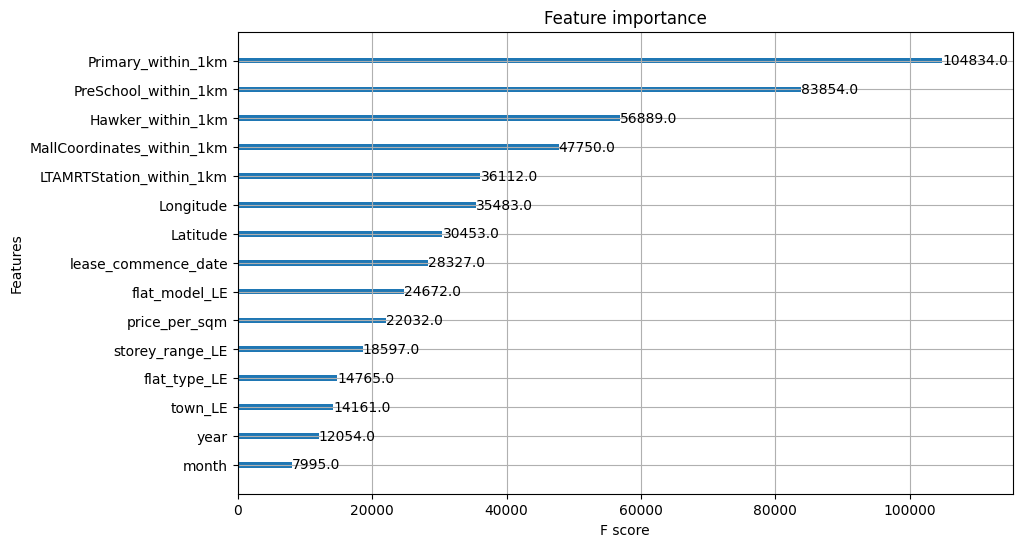

In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Retrieve feature names BEFORE converting to NumPy array
feature_names = df_train[features_final].columns.tolist()

# Plot feature importance with proper labels
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed
xgb.plot_importance(xgb_model, ax=ax, max_num_features=15, importance_type="weight")

# Apply actual feature names
ax.set_yticklabels(feature_names[:15])

plt.show()


In [12]:
# Example: Predict on new sample data (replace with actual feature values)
sample_data = X_test[:5]  # Taking first 5 rows from test set
predicted_prices = xgb_model.predict(sample_data)

print("Predicted Resale Prices:", predicted_prices)

Predicted Resale Prices: [401279.9  514455.53 330741.62 405441.53 276647.78]


# Predicting 

In [13]:
# Ensure mappings are clearly defined and correct
town_mapping = dict(df_train[['town', 'town_LE']].drop_duplicates().values)
flat_type_mapping = dict(df_train[['flat_type', 'flat_type_LE']].drop_duplicates().values)
flat_model_mapping = dict(df_train[['flat_model', 'flat_model_LE']].drop_duplicates().values)
storey_range_mapping = dict(df_train[['storey_range', 'storey_range_LE']].drop_duplicates().values)

# Verify keys clearly
print("Available towns:", list(town_mapping.keys()))
print("Available flat types:", list(flat_type_mapping.keys()))
print("Available flat models:", list(flat_model_mapping.keys()))
print("Available storey ranges:", list(storey_range_mapping.keys()))

Available towns: ['ANG MO KIO', 'BUKIT MERAH', 'SEMBAWANG', 'WOODLANDS', 'YISHUN', 'QUEENSTOWN', 'SENGKANG', 'JURONG WEST', 'BEDOK', 'GEYLANG', 'HOUGANG', 'BUKIT BATOK', 'CLEMENTI', 'TAMPINES', 'PUNGGOL', 'PASIR RIS', 'CHOA CHU KANG', 'BUKIT PANJANG', 'TOA PAYOH', 'KALLANG/WHAMPOA', 'BISHAN', 'MARINE PARADE', 'SERANGOON', 'JURONG EAST', 'CENTRAL AREA', 'BUKIT TIMAH']
Available flat types: ['4 ROOM', '5 ROOM', '2 ROOM', '3 ROOM', 'EXECUTIVE', '1 ROOM', 'MULTI-GENERATION']
Available flat models: ['New Generation', 'Standard', 'Model A', 'Simplified', 'Premium Apartment', 'Model A2', 'Improved', 'DBSS', 'Apartment', 'Maisonette', 'Adjoined flat', 'Type S1', '3Gen', 'Premium Apartment Loft', 'Model A-Maisonette', '2-room', 'Type S2', 'Multi Generation', 'Terrace', 'Improved-Maisonette', 'Premium Maisonette']
Available storey ranges: ['04 TO 06', '01 TO 03', '10 TO 12', '07 TO 09', '22 TO 24', '13 TO 15', '19 TO 21', '16 TO 18', '31 TO 33', '28 TO 30', '34 TO 36', '25 TO 27', '43 TO 45', '3

Predict the Pricing

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Example clearly chosen default values (verify they're in your dataset explicitly):
default_town = 'ANG MO KIO' if 'ANG MO KIO' in town_mapping else list(town_mapping.keys())[0]
default_flat_type = '4 ROOM'
default_flat_model = 'New Generation'
default_storey_range = '04 TO 06'

# Widgets using Dropdowns explicitly matched to your dictionary keys
town_widget = widgets.Dropdown(
    options=list(town_mapping.keys()),
    value=default_town if (default_town := 'ANG MO KIO') in town_mapping else list(town_mapping.keys())[0],
    description="Town:"
)

flat_type_widget = widgets.Dropdown(
    options=list(flat_type_mapping.keys()),
    value=default_flat_type if (default_flat_type := '4 ROOM') in flat_type_mapping else list(flat_type_mapping.keys())[0],
    description="Flat Type:"
)

flat_model_widget = widgets.Dropdown(
    options=list(flat_model_mapping.keys()),
    value=default_model if (default_model := 'New Generation') in flat_model_mapping else list(flat_model_mapping.keys())[0],
    description="Flat Model:"
)

storey_range_widget = widgets.Dropdown(
    options=list(storey_range_mapping.keys()),
    value=default_storey_range if default_storey_range in storey_range_mapping else list(storey_range_mapping.keys())[0],
    description="Storey Range:"
)

# Numeric widgets explicitly defined
month = widgets.IntText(value=4, description="Month:")
year = widgets.IntText(value=2021, description="Year:")
floor_area_sqm = widgets.FloatText(value=91.0, description="Floor Area (sqm):")
price_per_sqm = widgets.FloatText(value=4395.60, description="Price per sqm:")
lease_commence_date = widgets.IntText(value=1981, description="Lease Start Year:")
remaining_lease = widgets.IntText(value=59, description="Remaining Lease:")
Latitude = widgets.FloatText(value=1.3758152, description="Latitude:")
Longitude = widgets.FloatText(value=103.8381722, description="Longitude:")
LTAMRTStation_within_1km = widgets.IntText(value=3, description="MRTs ≤1km:")
MallCoordinates_within_1km = widgets.IntText(value=1, description="Malls ≤1km:")
Hawker_within_1km = widgets.IntText(value=18, description="Hawkers ≤1km:")
PreSchool_within_1km = widgets.IntText(value=26, description="Preschools ≤1km:")
Primary_within_1km = widgets.IntText(value=2, description="Primary ≤1km:")
Secondary_within_1km = widgets.IntText(value=1, description="Secondary ≤1km:")
JuniorCollege_within_1km = widgets.IntText(value=1, description="JC ≤1km:")
MixedLevel_within_1km = widgets.IntText(value=1, description="Mixed Levels ≤1km:")
NParks_within_1km = widgets.IntText(value=13, description="NParks ≤1km:")
Sports_within_1km = widgets.IntText(value=0, description="Sports ≤1km:")
remaining_lease = widgets.IntText(value=59, description="Remaining Lease:")
Latitude = widgets.FloatText(value=1.3758152, description="Latitude:")
Longitude = widgets.FloatText(value=103.8381722, description="Longitude:")

# Output widget clearly defined
output = widgets.Output()

# Corrected prediction function explicitly
def predict_price(_):
    with output:
        output.clear_output()

        # Prepare user input explicitly matching the trained features
        user_input = pd.DataFrame({
            "month": [month.value],
            "year": [year.value],
            "town_LE": [town_mapping[town_widget.value]],
            "flat_type_LE": [flat_type_mapping[flat_type_widget.value]],
            "storey_range_LE": [storey_range_mapping[storey_range_widget.value]],
            "price_per_sqm": [price_per_sqm.value],
            "flat_model_LE": [flat_model_mapping[flat_model_widget.value]],
            "lease_commence_date": [lease_commence_date.value],
            "Latitude": [Latitude.value],
            "Longitude": [Longitude.value],
            "LTAMRTStation_within_1km": [LTAMRTStation_within_1km.value],
            "MallCoordinates_within_1km": [MallCoordinates_within_1km.value],
            "Hawker_within_1km": [Hawker_within_1km.value],
            "PreSchool_within_1km": [PreSchool_within_1km.value],
            "Primary_within_1km": [Primary_within_1km.value],
            "Secondary_within_1km": [Secondary_within_1km.value],
            "JuniorCollege_within_1km": [JuniorCollege_within_1km.value],
            "MixedLevel_within_1km": [MixedLevel_within_1km.value],
            "NParks_within_1km": [NParks_within_1km.value],
            "Sports_within_1km": [Sports_within_1km.value],
            "remaining_lease": [remaining_lease.value],
            "town_LE": [town_mapping[town_widget.value]],
            "flat_type_LE": [flat_type_mapping[flat_type_widget.value]],
            "storey_range_LE": [storey_range_mapping[storey_range_widget.value]],
        })

        # Align columns explicitly 
        user_input = user_input.reindex(columns=features_final, fill_value=0)

        # Make prediction clearly
        predicted_price = xgb_model.predict(user_input)

        print(f"📌 Predicted Resale Price: SGD {predicted_price[0]:,.2f}")

# Predict button
predict_button = widgets.Button(description="Predict Resale Price")
predict_button.on_click(predict_price)

# Display widgets and button clearly
widgetbox = widgets.VBox([
    month, year, town_widget, flat_type_widget, storey_range_widget,
    flat_model_widget, floor_area_sqm, price_per_sqm,
    lease_commence_date, remaining_lease, Latitude, Longitude,
    LTAMRTStation_within_1km, MallCoordinates_within_1km, Hawker_within_1km,
    PreSchool_within_1km, Primary_within_1km, Secondary_within_1km,
    JuniorCollege_within_1km, MixedLevel_within_1km, NParks_within_1km,
    Sports_within_1km, predict_button, output
])

display(widgetbox)
